In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import csv
import pprint
import function as func
plt.rcParams['font.size'] = 15
np.set_printoptions(threshold=20)

# Setting
outdatadir='./output/yfactor_analysis_check/data'
outdir='./output/yfactor_analysis_check/figure'
doRebin = True # Rebinning in dat_to_array
rebinmethod = 0 # consider bin edges
onlyBefore = False

# Frequency
#freq_min = 15.5 # GHz
#freq_max = 16.0 # GHz
freq_min = 10.0 # GHz
freq_max = 18.0 # GHz

# Input 
indir_300K_ini = '/data/ms2840a/dosue-j/yfactor_300K_ini/2023-03/'
indir_300K_fin = '/data/ms2840a/dosue-j/yfactor_300K_fin/2023-03/'
indir_77K_ini  = '/data/ms2840a/dosue-j/yfactor_77K_ini/2023-03/'
indir_77K_fin  = '/data/ms2840a/dosue-j/yfactor_77K_fin/2023-03/'
infile_prefix = 'scan_FFT_'
infile_suffix = 'GHz_span2.50MHz_rbw300Hz_2.0sec_1counts_1runs'
# Number of files
nfile = 1
binary = True
temp_logfile = '/data/ms2840a/dosue-j/2023-03.log'

if not os.path.isdir(outdatadir):
    os.makedirs(outdatadir)
    pass
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    pass

column = [
        "freq", "freq_all",
        "Gain", "Trx", "Gain_err", "Trx_err", 
        "Gain_ini", "Trx_ini", "Gain_ini_err", "Trx_ini_err", 
        "P77_ini", "P300_ini", "T300_ini"
]
if not onlyBefore:
    column += [
        "Gain_fin", "Trx_fin", "Gain_fin_err", "Trx_fin_err", "P77_fin", "P300_fin", "T77_fin", "T300_fin"
        ]

# Functions
## function for each input file

In [2]:
def doYfactor(
    start, 
    Tamb_ini=300.,
    Tamb_fin=300.,
    rbw_yfac = 300.,
    outfile = "aho.csv",
    nfile=1,
    onlyBefore=False,
    verbose=1,
    result_all = None,
    ):
    rbw = func.rbw
    binwidth = func.binwidth
    
    path_300K_ini = f"{indir_300K_ini}/{infile_prefix}{start}{infile_suffix}"
    path_300K_fin = f"{indir_300K_fin}/{infile_prefix}{start}{infile_suffix}"
    path_77K_ini  =  f"{indir_77K_ini}/{infile_prefix}{start}{infile_suffix}"
    path_77K_fin  =  f"{indir_77K_fin}/{infile_prefix}{start}{infile_suffix}"
    fmin = float(start)*1e+9 + 250e+3
    fmax = float(start)*1e+9 + 250e+3 + 2e+6
    
    # Create result containers
    result = { _col:[] for _col in column }
    if result_all is None: 
        result_all = { _col:[] for _col in column }
        pass
    
    for n in range(nfile):
        filesuffix = f'_{n}' if nfile > 1 else  ''
        # 300 K initial
        path = f'{path_300K_ini}{filesuffix}.dat'
        f, Wamb_ini, Wamb_ini_err = func.dat_to_array(path, doRebin=doRebin, rebinmethod=rebinmethod, rbw=rbw, binwidth=binwidth, binary=binary)
        f, Wamb_ini, Wamb_ini_err = func.cut_data(f, Wamb_ini, Wamb_ini_err, fmin=fmin, fmax=fmax)
               
        # 77 K initial
        path = f'{path_77K_ini}{filesuffix}.dat'
        f, WLN2_ini, WLN2_ini_err = func.dat_to_array(path, doRebin=doRebin, rebinmethod=rebinmethod, rbw=rbw, binwidth=binwidth, binary=binary)
        f, WLN2_ini, WLN2_ini_err = func.cut_data(f, WLN2_ini, WLN2_ini_err, fmin=fmin, fmax=fmax)
            
        Gain_ini, Trx_ini, Gain_ini_err, Trx_ini_err \
        = func.yfactor_analysis(f, Wamb_ini, WLN2_ini, Wamb_ini_err, WLN2_ini_err, Tamb_ini, rbw=rbw_yfac)
        if verbose > 0: print('Gain_ini[0]:', func.ratio_to_dB(Gain_ini[0]), 'dB')
        
        if not onlyBefore:
            # 300 K final
            path = f'{path_300K_fin}{filesuffix}.dat'
            f, Wamb_fin, Wamb_fin_err = func.dat_to_array(path, doRebin=doRebin, rebinmethod=rebinmethod, rbw=rbw, binwidth=binwidth, binary=binary)
            f, Wamb_fin, Wamb_fin_err = func.cut_data(f, Wamb_fin, Wamb_fin_err, fmin=fmin, fmax=fmax)
            
            # 77 K final
            path = f'{path_77K_fin}{filesuffix}.dat'
            f, WLN2_fin, WLN2_fin_err = func.dat_to_array(path, doRebin=doRebin, rebinmethod=rebinmethod, rbw=rbw, binwidth=binwidth, binary=binary)
            f, WLN2_fin, WLN2_fin_err = func.cut_data(f, WLN2_fin, WLN2_fin_err, fmin=fmin, fmax=fmax)
                
            Gain_fin, Trx_fin, Gain_fin_err, Trx_fin_err \
            = func.yfactor_analysis(f, Wamb_fin, WLN2_fin, Wamb_fin_err, WLN2_fin_err, Tamb_fin, rbw=rbw_yfac)
            if verbose > 0: print('Gain_fin[0]:', func.ratio_to_dB(Gain_fin[0]), 'dB')
            pass
  
        if not onlyBefore:
            Gain = (Gain_ini + Gain_fin) / 2
            Trx = (Trx_ini + Trx_fin) / 2
            Gain_err = (Gain_ini_err**2 + Gain_fin_err**2)**0.5 / 2
            Trx_err = (Trx_ini_err**2 + Trx_fin_err**2)**0.5 / 2
        else:
            Gain = Gain_ini
            Trx = Trx_ini
            Gain_err = Gain_ini_err
            Trx_err = Trx_ini_err
            pass
        
        result["freq"].append(start) # start frequency of each measurement (2MHz step)
        result["freq_all"] += f.tolist() # frequency array (<binwidth=2kHz> step)
        result["Gain"] += Gain.tolist()
        result["Trx"] += Trx.tolist()
        result["Gain_err"] += Gain_err.tolist()
        result["Trx_err"] += Trx_err.tolist()
        result["Gain_ini"] += Gain_ini.tolist()
        result["Trx_ini"] += Trx_ini.tolist()
        result["Gain_ini_err"] += Gain_ini_err.tolist()
        result["Trx_ini_err"] += Trx_ini_err.tolist()
        result["P77_ini"] += WLN2_ini.tolist()
        result["P300_ini"] += Wamb_ini.tolist()
        result["T300_ini"] += [Tamb_ini]*len(Gain)
        if not onlyBefore:
            result["Gain_fin"] += Gain_fin.tolist()
            result["Trx_fin"] += Trx_fin.tolist()
            result["Gain_fin_err"] += Gain_fin_err.tolist()
            result["Trx_fin_err"] += Trx_fin_err.tolist()
            result["P77_fin"] += WLN2_fin.tolist()
            result["P300_fin"] += Wamb_fin.tolist()
            result["T300_fin"] += [Tamb_fin]*len(Gain)
            pass
        pass # End of loop over files
    
    for _col in column:
        result_all[_col] += result[_col]
        pass
    
    # List --> np.array in result
    for _col in column:
        result[_col] = np.array(result[_col])
        pass

    # Save mean of y-factor result in a 2MHz span
    with open(outfile, "a") as f:
        writer = csv.writer(f)
        rows = [
            start, 
            np.mean(result["Gain"]), 
            np.mean(result["Trx"]), 
            np.mean(result["Gain_err"]**2)**0.5/np.sqrt(nfile), 
            np.mean(result["Trx_err"]**2)**0.5/np.sqrt(nfile), 
            np.mean(result["Gain_ini"]), 
            np.mean(result["Trx_ini"]), 
            np.mean(result["Gain_ini_err"]**2)**0.5/np.sqrt(nfile), 
            np.mean(result["Trx_ini_err"]**2)**0.5/np.sqrt(nfile), 
            np.mean(result["P77_ini"]), 
            np.mean(result["P300_ini"]), 
            np.mean(result["T300_ini"]), 
        ]
        if not onlyBefore:
            rows += [
                np.mean(result["Gain_fin"]), 
                np.mean(result["Trx_fin"]), 
                np.mean(result["Gain_fin_err"]**2)**0.5/np.sqrt(nfile), 
                np.mean(result["Trx_fin_err"]**2)**0.5/np.sqrt(nfile),
                np.mean(result["P77_fin"]), 
                np.mean(result["P300_fin"]), 
                np.mean(result["T300_fin"]), 
                ]
            pass
        writer.writerow(rows)
        pass
    return result_all

## Function to loop over frequency

In [3]:
def yfactor_data(onlyBefore=False, temp_ini=21, temp_fin=21, logfile='', verbose=0):
    # RBW for y-factor calculation
    if doRebin:
        rbw_yfac = func.binwidth # 2kHz
    else:
        rbw_yfac = func.rbw
        pass
    
    yfactor_dir = f'{outdatadir}'
    if not os.path.isdir(yfactor_dir):
        os.makedirs(yfactor_dir)
        pass
    
    # ログファイルから 300K 黒体の温度を取得
    temp_dict = {}
    useTempLog = (temp_ini is None) or (onlyBefore == False and temp_fin is None)
    if useTempLog:
        with open(logfile, 'r') as f:
            reader = csv.DictReader(f, delimiter=',', skipinitialspace=True, )
            freq_column='# freq[GHz]'
            for row in reader:
                freq = row[freq_column]
                temp_ini1 = float(row['300K_temp_before'])
                temp_ini2 = float(row['300K_temp_before2'])
                temp_fin1 = float(row['300K_temp_after'])
                temp_fin2 = float(row['300K_temp_after2'])
                temp_dict[freq] = {'ini1':temp_ini1, 'ini2':temp_ini2, 'fin1':temp_fin1, 'fin2':temp_fin2}
                pass
            pass
        print(f'Temperature data key frequencies: {temp_dict.keys()}')
        pass
    
    # Y-factor result container
    result_all = None
    
    # Loop over frequencies with 100MHz spans
    # Each 100MHz span has one set of calibration parameters
    i_start100MHz, i_end100MHz, i_100MHz = func.get_loop_index_each100MHz(freq_min, freq_max)
    #print(i_start100MHz, i_end100MHz, i_100MHz)
    for i in range(i_start100MHz, i_end100MHz, i_100MHz):
        # Get frequency in filename
        tmp1, start_100MHz_str, tmp2 = func.get_file_freq(i)
        #print(tmp1, start_100MHz_str)
        i_start2MHz, i_end2MHz, i_2MHz = func.get_loop_index_each2MHz(i)
 
        # Temperature (temporary values)
        if useTempLog:
            T_ini = temp_dict[start_100MHz_str]['ini1'] + 273.15 # [K]
            T_fin = temp_dict[start_100MHz_str]['fin1'] + 273.15 # [K]
        else:
            T_ini = temp_ini + 273.15 # [K]
            T_fin = temp_fin + 273.15 # [K]
            pass
        if verbose > 0: print(f'Temperature for {start_100MHz_str} GHz:{T_in} K / {T_fin} K')
        
        outfile = f"{yfactor_dir}/start_{start_100MHz_str}GHz.csv"
        with open(outfile, "w") as f:
            writer = csv.writer(f)
            writer.writerow(column)
            pass
           
        # Loop over 2MHz datas in a 100MHz span
        for k, j in enumerate(range(i_start2MHz, i_end2MHz, i_2MHz)):
            if k%25 == 0: print(f'*** Starting freq = {j*1e-9:.6f} GHz ***')
            start_Hz = j
            center_Hz = start_Hz + i_2MHz/2
            start_str, start_100MHz_str, is_add_data\
                = func.get_file_freq(center_Hz, verbose=0)
            
            # Do & save the yfactor calibration
            result_all = doYfactor(start=start_str, Tamb_ini=T_ini, Tamb_fin=T_fin, 
                      rbw_yfac=rbw_yfac, outfile = outfile, onlyBefore=onlyBefore, nfile=nfile,
                      verbose=verbose, result_all=result_all)
            pass # End of loop over 2MHz datas in a 100MHz span
        pass # End of loop over 100MHz span from 18GHz to 26.5GHz
    
    return result_all

# [Main] Y-factor for all frequency range

In [4]:
# Take a long time
result_all = yfactor_data(onlyBefore=onlyBefore, temp_ini=None, temp_fin=None, logfile=temp_logfile)

Temperature data key frequencies: dict_keys(['9.9', '10.0', '10.1', '10.2', '10.3', '10.4', '10.5', '10.6', '10.7', '10.8', '10.9', '11.0', '11.1', '11.2', '11.3', '11.4', '11.5', '11.6', '11.7', '11.8', '11.9', '12.0', '12.1', '12.2', '12.3', '12.4', '12.5', '12.6', '12.7', '12.8', '12.9', '13.0', '13.1', '13.2', '13.3', '13.4', '13.5', '13.6', '13.7', '13.8', '13.9', '14.0', '14.1', '14.2', '14.3', '14.4', '14.5', '14.6', '14.7', '14.8', '14.9', '15.0', '15.1', '15.2', '15.3', '15.4', '15.5', '15.6', '15.7', '15.8', '15.9', '16.0', '16.1', '16.2', '16.3', '16.4', '16.5', '16.6', '16.7', '16.8', '16.9', '17.0', '17.1', '17.2', '17.3', '17.4', '17.5', '17.6', '17.7', '17.8', '17.9'])
*** Starting freq = 9.999750 GHz ***
*** Starting freq = 10.049750 GHz ***
*** Starting freq = 10.099750 GHz ***
*** Starting freq = 10.149750 GHz ***
*** Starting freq = 10.199750 GHz ***
*** Starting freq = 10.249750 GHz ***
*** Starting freq = 10.299750 GHz ***
*** Starting freq = 10.349750 GHz ***
*** 

In [5]:
for key in result_all.keys():
    result_all[key] = np.array(result_all[key])
    pass

## Plot y-factor results from result_all

In [6]:
def plot_yfactor(result, xlim=None, nAve=1, 
                 freq_key='freq_all', gain_key='Gain', Trx_key='Trx', 
                 gain_ini_key='Gain_ini', gain_fin_key='Gain_fin'):
    plt.rcParams["font.size"] = 15
    if nAve==1:
        fig, axes = plt.subplots(3,1,figsize=(16,12), squeeze=False, sharex=False)
    else:
        fig, axes = plt.subplots(5,1,figsize=(16,20), squeeze=False, sharex=False)
        pass
    plt.suptitle("Calibration Result")
    if nAve==1:
        y = result
    else:
        y = {}
        y[freq_key], tmp = func.average_list(result[freq_key], nAve)
        y[gain_key], y[gain_key+'_err'] = func.average_list(result[gain_key], nAve)
        y[Trx_key], y[Trx_key+'_err'] = func.average_list(result[Trx_key], nAve)
        y[gain_ini_key], y[gain_ini_key+'_err'] = func.average_list(result[gain_ini_key], nAve)
        y[gain_fin_key], y[gain_fin_key+'_err'] = func.average_list(result[gain_fin_key], nAve)
        pass

    ax = axes[0][0]
    ax.scatter(y[freq_key]*1e-9, 10*np.log10(y[gain_key]), s=20, color="blue", label="Gain")
    ax.set_ylabel("Gain [dB]")
    ax.grid(True)
    ax.set_xlim(xlim)
    
    ax = axes[1][0]
    ax.scatter(y[freq_key]*1e-9, y[Trx_key], s=20, color="blue", label="Trx")
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel(r"$T_{\rm rx}$ [K]")
    ax.grid(True)
    ax.set_xlim(xlim)
    
    ax = axes[2][0]
    ax.scatter(y[freq_key]*1e-9, y[gain_ini_key]/y[gain_fin_key], s=20, color="blue", label="Gain ratio")
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel(r"$Gain before/after$")
    ax.grid(True)
    ax.set_xlim(xlim)
    ax.set_ylim([0.9,1.1])

    if nAve>1:
        ax = axes[3][0]
        gain_err_ratio = y[gain_key+'_err']/y[gain_key]
        gain_diff_ratio = np.diff(y[gain_key])/y[gain_key][:-1]
        ax.scatter(y[freq_key]*1e-9, gain_err_ratio, s=20, color="blue", 
                   label=f"Gain error from std: max={max(abs(gain_err_ratio))*100:.2f} %")
        ax.scatter(y[freq_key][:-1]*1e-9, gain_diff_ratio, s=20, color="cyan", 
                   label=f"Gain diff. from neighbor: max={max(abs(gain_diff_ratio))*100:.2f} %")
        ax.set_ylabel("Ratio")
        ax.legend(frameon=False)
        ax.grid(True)
        ax.set_xlim(xlim)
        ax.set_ylim([-0.05,0.05])
        ax.set_yticks(np.arange(-0.05,0.06,0.01))
        
        ax = axes[4][0]
        Trx_err_ratio = y[Trx_key+'_err']/y[Trx_key]
        Trx_diff_ratio = np.diff(y[Trx_key])/y[Trx_key][:-1]
        ax.scatter(y[freq_key]*1e-9, Trx_err_ratio, s=20, color="blue", 
                   label=f"Trx error from std: max={max(abs(Trx_err_ratio))*100:.2f} %")
        ax.scatter(y[freq_key][:-1]*1e-9, Trx_diff_ratio, s=20, color="cyan", 
                   label=f"Trx diff from neighbor: max={max(abs(Trx_diff_ratio))*100:.2f} %")
        ax.set_ylabel("Ratio")
        ax.legend(frameon=False)
        ax.grid(True)
        ax.set_xlim(xlim)
        ax.set_ylim([-0.05,0.05])
        ax.set_yticks(np.arange(-0.05,0.06,0.01))
        pass
    fig.tight_layout()
    return fig

### Plot y-factor results from result_all (binwidth = {{func.binwidth}} )

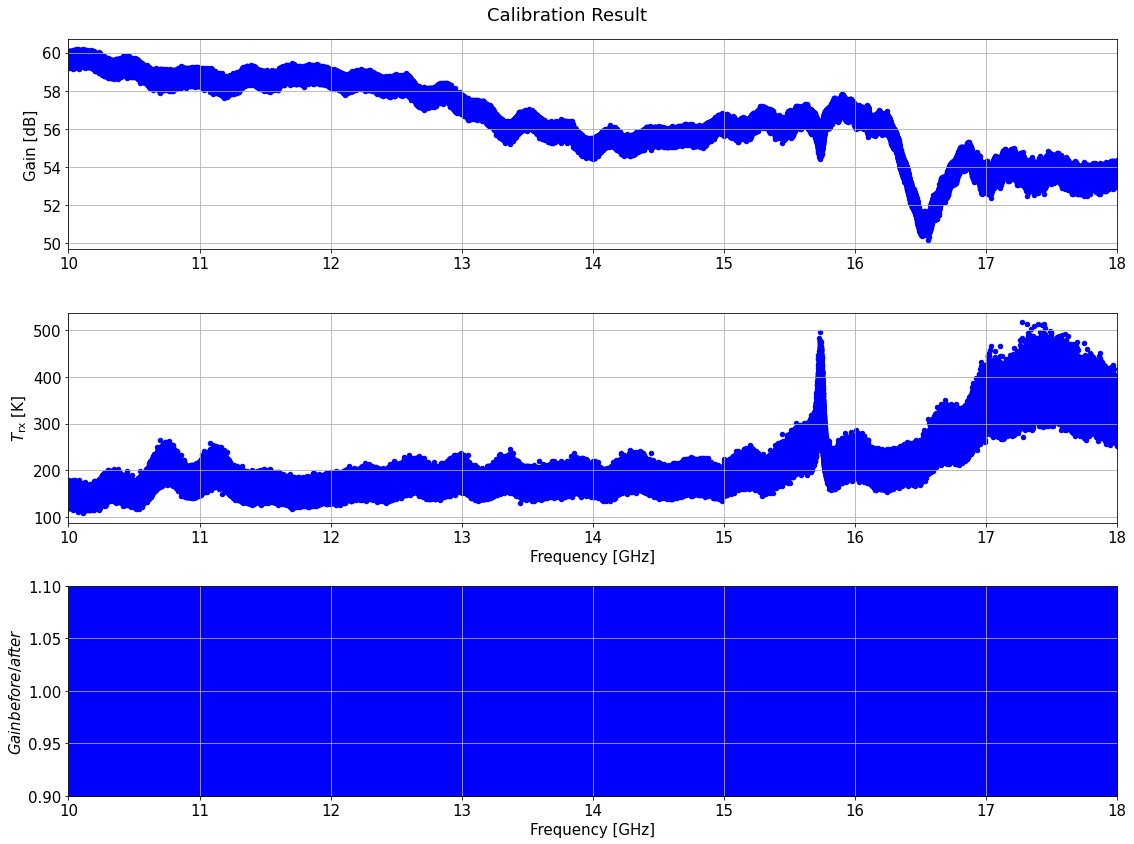

In [13]:
#xlim = [15.7, 15.8]
xlim = [freq_min, freq_max]
fig = plot_yfactor(result_all, xlim=xlim)
fig.savefig(f"{outdir}/gain_Trx_{xlim[0]:.1f}-{xlim[1]:.1f}_result_all.png")

## Plot y-factor results from result_all after averaging (binwidth = {{func.binwidth*1000}} )

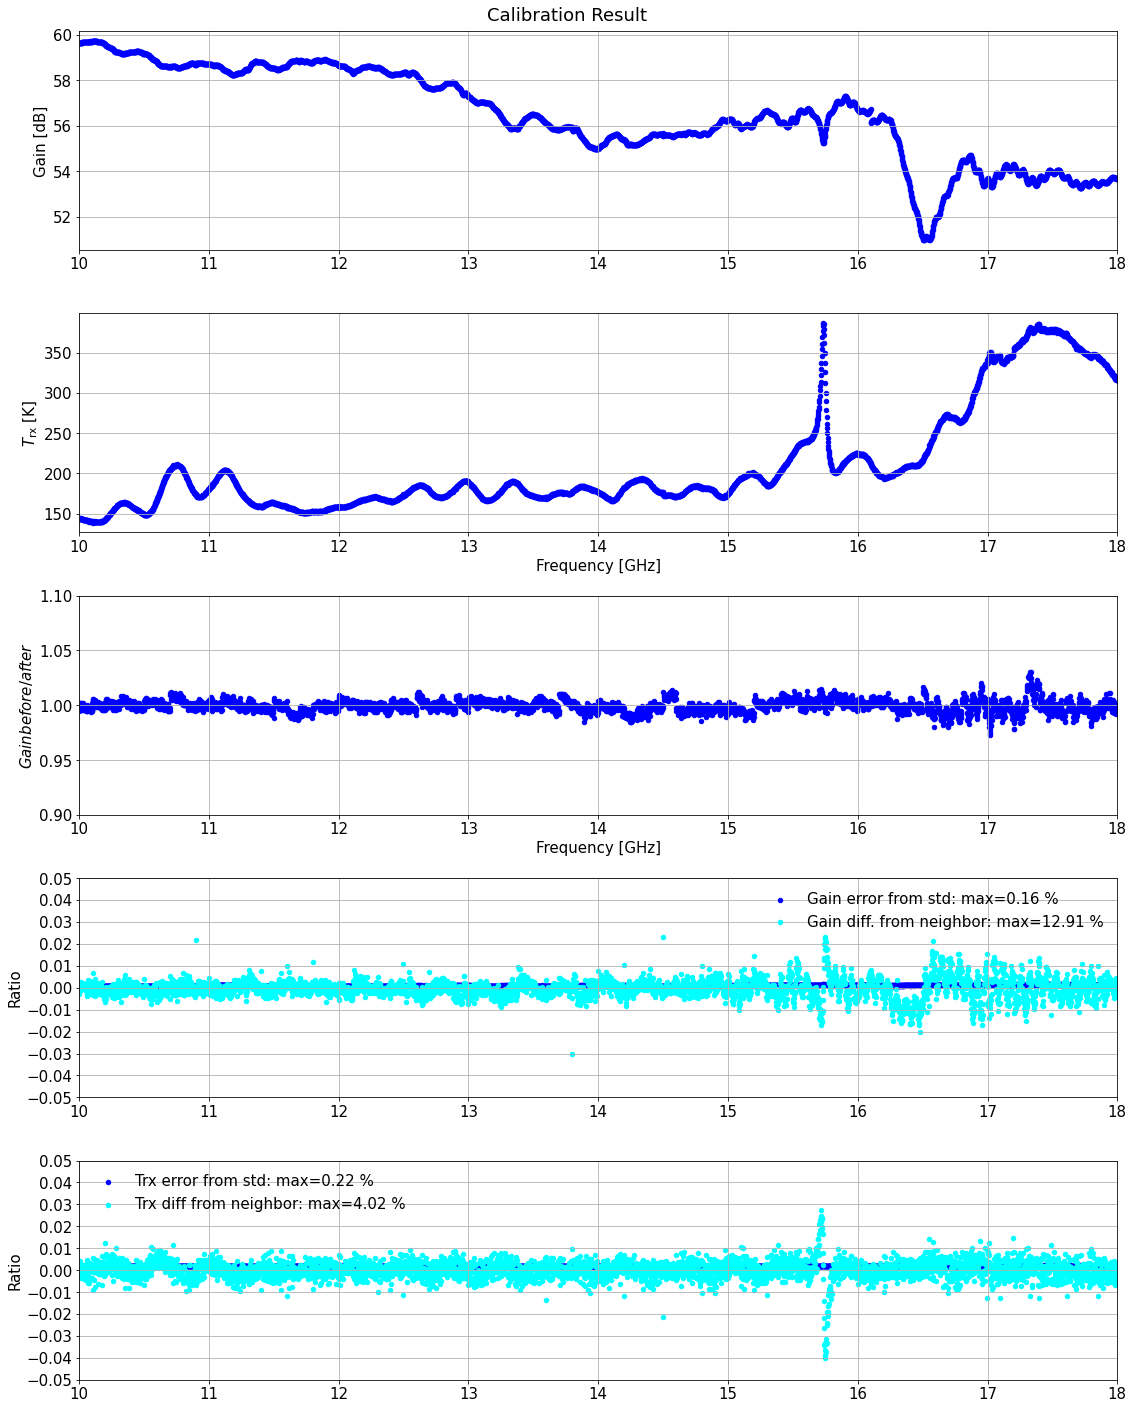

In [8]:
nAve = 1000
binwidth = func.binwidth * nAve # Hz
fig = plot_yfactor(result_all, xlim=xlim, nAve=nAve)
fig.savefig(f"{outdir}/gain_Trx_{xlim[0]:.1f}-{xlim[1]:.1f}_result_all_binwidth{binwidth*1e-3:.0f}kHz.png")

## Plot y-factor results from result_all after averaging (binwidth = {{func.binwidth*100}} )

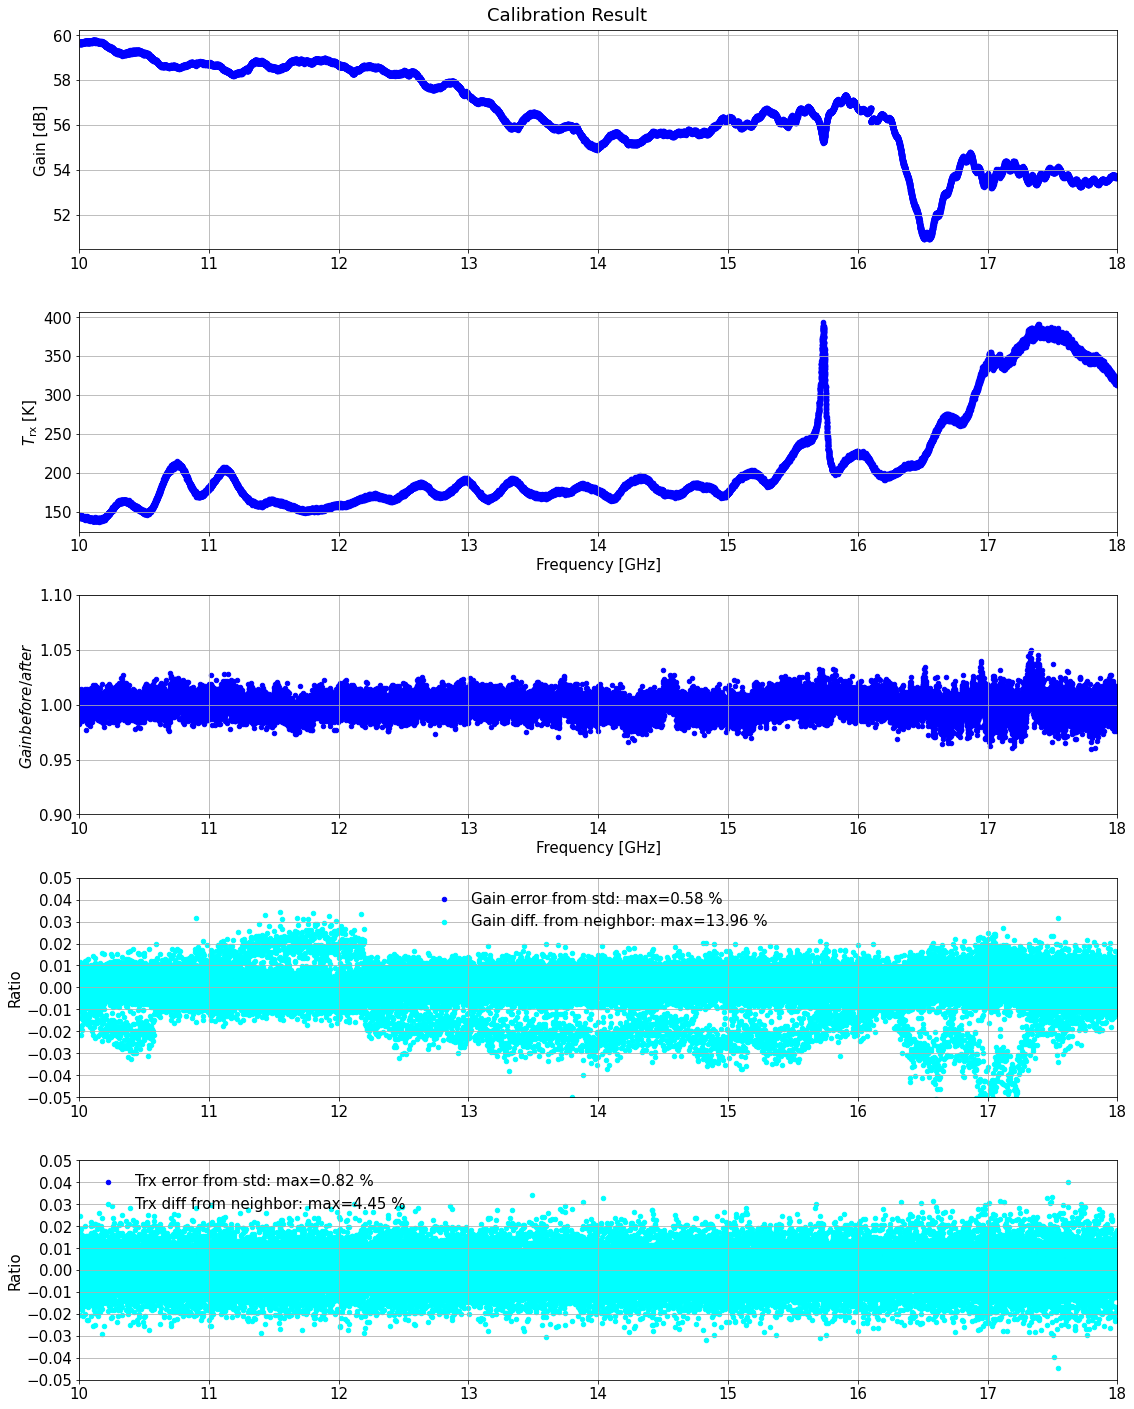

In [9]:
nAve = 100
binwidth = func.binwidth * nAve # Hz
fig = plot_yfactor(result_all, xlim=xlim, nAve=nAve)
fig.savefig(f"{outdir}/gain_Trx_{xlim[0]:.1f}-{xlim[1]:.1f}_result_all_binwidth{binwidth*1e-3:.0f}kHz.png")

## Combine all y-factor results in one file from files

In [10]:
combined_file = f"{outdatadir}/yfactor_result_each2MHz.csv"
with open(combined_file, "w") as f:
    writer = csv.writer(f)
    
    # Loop over frequencies with 100MHz spans
    i_start100MHz, i_end100MHz, i_100MHz = func.get_loop_index_each100MHz(freq_min, freq_max)
    for i in range(i_start100MHz, i_end100MHz, i_100MHz):
        # Get frequency in filename
        tmp1, start_100MHz_str, tmp2 = func.get_file_freq(i)
        
        _filename =  f"{outdatadir}/start_{start_100MHz_str}GHz.csv"
        data = func.csv_to_array(_filename)
        keys = list(data.keys())
        if i == i_start100MHz: writer.writerow(keys)
        
        print(keys)
        print(data[keys[0]])
        print('size of y-factor data over 100MHz', len(data[keys[0]]))
        
        for j in range(len(data[keys[0]])):
            _result = [ data[key][j] for key in keys ]
            writer.writerow(_result)
            pass # End of loop over 100MHz
        
        pass # End of loop over all frequency
    pass # Close the output file

y = func.csv_to_array(combined_file)

['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[ 9.99975 10.00175 10.00375 ... 10.09375 10.09575 10.09775]
size of y-factor data over 100MHz 50
['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[10.09975 10.10175 10.10375 ... 10.19375 10.19575 10.19775]
size of y-factor data over 100MHz 50
['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[10.19975 10.20175 10.20375 ... 10.29375 10.29575 10.29775]
si

['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[16.49975 16.50175 16.50375 ... 16.59375 16.59575 16.59775]
size of y-factor data over 100MHz 50
['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[16.59975 16.60175 16.60375 ... 16.69375 16.69575 16.69775]
size of y-factor data over 100MHz 50
['freq', 'freq_all', 'Gain', 'Trx', 'Gain_err', 'Trx_err', 'Gain_ini', 'Trx_ini', 'Gain_ini_err', 'Trx_ini_err', 'P77_ini', 'P300_ini', 'T300_ini', 'Gain_fin', 'Trx_fin', 'Gain_fin_err', 'Trx_fin_err', 'P77_fin', 'P300_fin', 'T77_fin', 'T300_fin']
[16.69975 16.70175 16.70375 ... 16.79375 16.79575 16.79775]
si

## Plot combined y-factor result

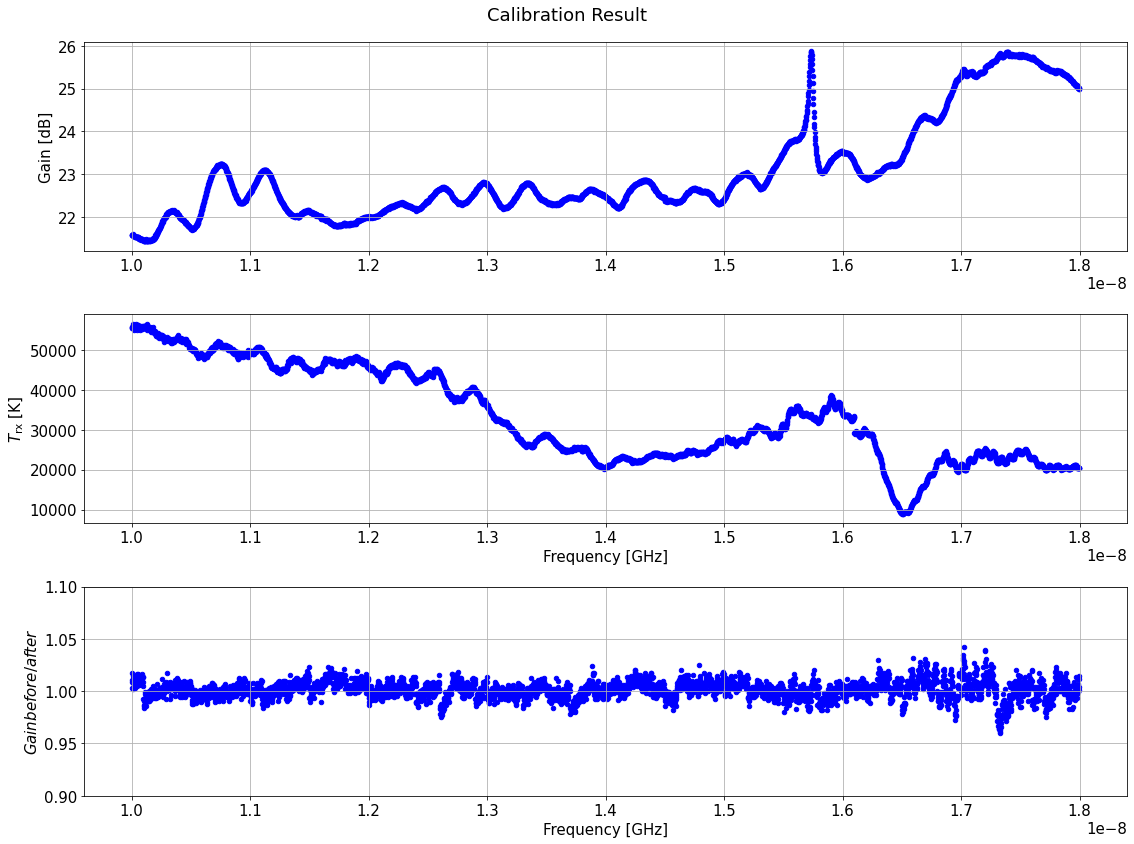

In [11]:
fig = plot_yfactor(y, xlim=None, nAve=1, 
                   freq_key='freq', gain_key='Gain', Trx_key='Trx', 
                   gain_ini_key='Gain_ini', gain_fin_key='Gain_fin')
fig.savefig(f"{outdir}/gain_Trx_{freq_min:.1f}-{freq_max:.1f}.png")

0.00839570081625198
1.0016101175346401
0.020943547106132998


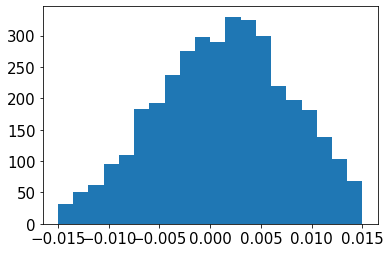

In [12]:
gain_ratio = y["Gain_ini"]/y["Gain_fin"]
plt.hist(gain_ratio - 1, bins=20, range=(-0.015, 0.015))
gain_ratio_std = np.std(gain_ratio)
gain_ratio_ave = np.average(gain_ratio)
gain_ratio_maxdiff = np.max(np.abs(gain_ratio - 1))
print(gain_ratio_std)
print(gain_ratio_ave)
print(gain_ratio_maxdiff / 2)